In [43]:
import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import  math

imageSize = 250

primaryImage = np.load('finalSimFile3DPrimaryOnly.npy')
secondaryImage = np.load('finalSimFile3DwithSecond.npy')
#poreImage = poreImage[0:imageSize, 0:imageSize, 0:250]

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']
# with open('velNorm.pkl', 'rb') as fin :
#     velNorm = pickle.load(fin)
velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters
#poreVelocity = np.reshape(poreVelocity, (imageSize, imageSize, imageSize))

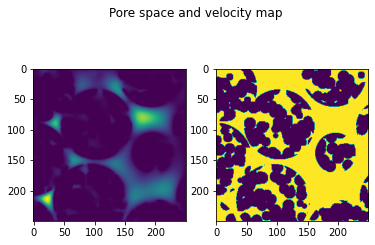

In [44]:
slice = 49

secondaryImage = np.transpose(secondaryImage)
primaryImage = np.transpose(primaryImage)

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

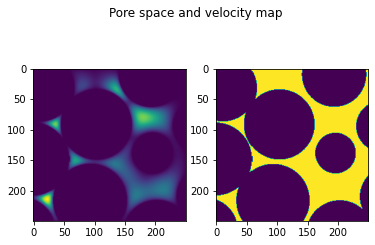

In [45]:
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])



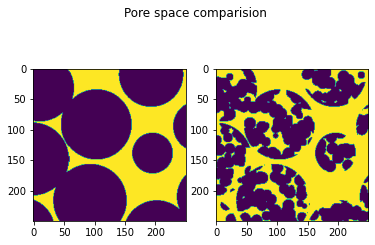

In [46]:
slice = 49

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space comparision')
p1.imshow(primaryImage[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

In [47]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1512
Peaks after trimming saddle points:  1013
Peaks after trimming nearby peaks:  991
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 991/991 [00:09<00:00, 103.78it/s]


In [48]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)




------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  135
Peaks after trimming saddle points:  119
Peaks after trimming nearby peaks:  107
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 107/107 [00:05<00:00, 19.56it/s]


In [49]:
cubeSize = len(secondaryImage)

velocitiesSecondary = {}

regionMapSecondary = snowFiltSecondary.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMapSecondary[a,b,c])
            if key != '0.0':
                if key in velocitiesSecondary:
                    velocitiesSecondary[key].append(velDataNormSecondary[a,b,c])
                else:
                    velocitiesSecondary.setdefault(key,[])
                    velocitiesSecondary[key].append(velDataNormSecondary[a,b,c])

In [50]:
nRegions = np.unique(snowFiltSecondary.regions).size
poreDiamVec = np.zeros(nRegions,)
velNormPoreVecSecondary = np.zeros(nRegions,)
velAllPoreVec = []

# stopping here
for a in range(0, poreInfoSecondary['pore.diameter'].size):
    poreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]
    velNormPoreVecSecondary[a] = np.median(velocitiesSecondary.get(str(a)))
    test = [velocitiesSecondary.get(str(a))]
    velNormPoreVecSecondary.append([velocitiesSecondary.get(str(a))])

#Append one more time for indexing
velNormPoreVecSecondary.append([0])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [36]:
cubeSize = len(primaryImage)

velocitiesPrimary= {}

regionMapPrimary = snowFiltPrimary.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMapPrimary[a,b,c])
            if key != '0.0':
                if key in velocitiesPrimary:
                    velocitiesPrimary[key].append(velDataNormPrimary[a,b,c])
                else:
                    velocitiesPrimary.setdefault(key,[])
                    velocitiesPrimary[key].append(velDataNormPrimary[a,b,c])

In [ ]:
nRegions = np.unique(snowFiltPrimary.regions).size
poreDiamVec = np.zeros(nRegions,)
velNormPoreVecPrimary= np.zeros(nRegions,)
velAllPoreVec = []

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    poreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]
    velNormPoreVecPrimary[a] = np.median(velocitiesSecondary.get(str(a)))
    test = [velocitiesSecondary.get(str(a))]
    velNormPoreVecPrimary.append([velocitiesSecondary.get(str(a))])

#Append one more time for indexing
velNormPoreVecPrimary.append([0])

In [40]:
# Bin pore diameter data
#max(poreInfo['pore.diameter'])
#min(poreInfo['pore.diameter'])
n_bins = 100

poreBins = np.linspace(0.1,60,n_bins)
poreDiamVec = poreInfoSecondary['pore.diameter']
binnedInd = np.digitize(poreDiamVec, poreBins)

allKeys = np.round(poreBins,2)
binnedPoreDiam = dict.fromkeys(allKeys)

for i in binnedPoreDiam.keys():
    binnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(binnedInd)):
    key=poreBins[binnedInd[i]]
    key = round(key,2)
    binnedPoreDiam[key].append(poreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])
#regionLabel[i].append

In [42]:
####################################################
# Bin Velocity data
nVelBins = 100
velBins = np.logspace(-9,-4,nVelBins)
binnedInd = np.digitize(velDataNormSecondary, velBins)
velBinsLin = np.exp(velBins);

allKeys = velBins
binnedPoreVelNorm = dict.fromkeys(allKeys)

for i in binnedPoreVelNorm.keys():
    binnedPoreVelNorm[i] = []

 # currently storing all of the velocities in a pore of a given diameter
for i in range(1, len(binnedInd)):
    key=velBins[binnedInd[i]]
    binnedPoreVelNorm[key].append(velDataNormSecondary[i])

TypeError: unhashable type: 'numpy.ndarray'

In [39]:
poreBins = np.linspace(0.1,60,n_bins-1)
poreDiamVec = poreInfo['pore.diameter']
binnedInd = np.digitize(poreDiamVec, poreBins)
velBins = np.logspace(-9,-4,nVelBins+1)

allKeys = np.round(poreBins,2)
binnedPoreDispAtDiam = dict.fromkeys(allKeys)

for i in binnedPoreDispAtDiam.keys():
    binnedPoreDispAtDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(binnedInd)):
    key=poreBins[binnedInd[i]]
    key = round(key,2)
    i =3
    test = allPoreDispVector[i]
    binnedPoreDispAtDiam[key].extend(allPoreDispVector[i])
#regionLabel[i].append

imageMap = np.zeros([n_bins, nVelBins])
keyList = list(binnedPoreDispAtDiam.keys())
for i in range(1,len(keyList)):
    key=keyList[i]
    temp = np.histogram(binnedPoreDispAtDiam[key],velBins,density='True')
    temp2 = temp[0][:]
    temp2[:] = [0 if math.isnan(ele) else ele for ele in temp2]
    imageMap[i,:] =  temp2


NameError: name 'poreInfo' is not defined

In [ ]:
poreBins = np.linspace(0.1,60,n_bins)
velBins = np.logspace(-9,-4,nVelBins)

filtMap = sp.ndimage.gaussian_filter(imageMap, 6)
levels = np.linspace(filtMap.min(),filtMap.max(),100)
#levels = np.flipud(levels)
# This should be an intensity plot of pore diameter and displacement
fig2 = plt.figure()
plt.suptitle('Pore displacement - pore diameter map')

ax1 = fig2.add_subplot(1,2,2)
filtMapFlip = np.flipud(filtMap)
ax1.imshow(filtMapFlip)

#xi = np.linspace(-2.1,2.1,100)
#yi = np.linspace(-2.1,2.1,100)
#zi = sp.interpolate.griddata((velBins, poreBins), filtMap, (xi[None,:], yi[:,None]), method='cubic')

ax2 = fig2.add_subplot(1,2,1)
ax2.contour(poreBins,velBins,filtMap,levels)
#plt.contourf(xi,yi,zi)


